<a href="https://colab.research.google.com/github/hrumst/ML/blob/master/submission_9_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%config IPComplater.greedy = True

In [2]:
from google.colab import drive
drive.mount('./DRIVE', force_remount=True).

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./DRIVE


In [3]:
!pip show keras

Name: Keras
Version: 2.2.5
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: keras-preprocessing, h5py, numpy, keras-applications, pyyaml, six, scipy
Required-by: 


In [0]:
!pip freeze > requirements.txt

In [0]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# keras
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization, Bidirectional, Lambda, Concatenate
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.optimizers import Adam, Adamax
# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

DATASET_PATH = './DRIVE/My Drive/colab_data/Test_classification/'

import os
for dirname, _, filenames in os.walk(DATASET_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [0]:
# seed values
SEED = 42
random.seed = SEED
np.random.seed(seed=SEED)

# SETUP
В setup выносим основные настройки

In [0]:
# MODEL
BATCH_SIZE  = 128
EPOCH       = 10
VAL_SPLIT   = 0.15  #15%

# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 10000
# Max number of words in each complaint.
MAX_TEXT_SEQUENCE_LENGTH = 170
MAX_NAME_SEQUENCE_LENGTH = 5

DATA_PATH = DATASET_PATH

# Data
#### TRAIN

In [0]:
train_df = pd.read_csv(DATA_PATH+'train.csv',)

In [9]:
train_df.head()

,name,genre,text
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
name     54214 non-null object
genre    54214 non-null object
text     54214 non-null object
dtypes: object(3)
memory usage: 1.2+ MB


Text(0, 0.5, 'Counts')

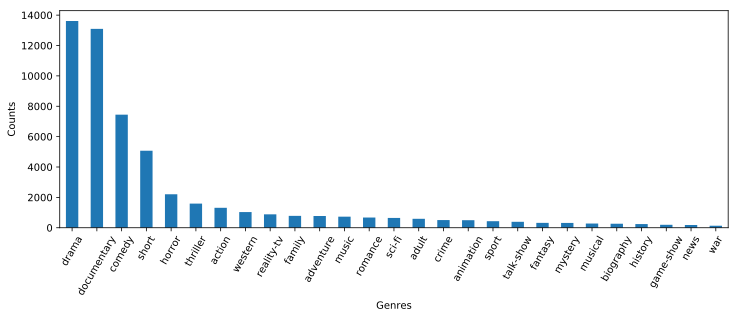

In [11]:
train_df.genre.value_counts().plot(kind='bar',figsize=(12,4),fontsize=10)
plt.xticks(rotation=60)
plt.xlabel("Genres",fontsize=10)
plt.ylabel("Counts",fontsize=10)

### TEST

In [12]:
test_df = pd.read_csv(DATA_PATH+'test.csv')
test_df.head()

,name,text
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),Before he was known internationally as a mart...


### Target

In [13]:
Y = pd.get_dummies(train_df.genre)
CLASS_NUM = Y.shape[1]
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (54214, 27)


In [0]:
Y.head()

,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,fantasy,game-show,history,horror,music,musical,mystery,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Preprocessing

### Clean Data

In [29]:
import re
regex = re.compile(r"\(.{4}\)", re.IGNORECASE)
train_df['name'] = train_df['name'].apply(lambda x : regex.sub("", x))

train_df.head()

,name,genre,text
0,Oscar et la dame rose,drama,Listening in to a conversation between his do...
1,Cupid,thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful",adult,As the bus empties the students for their fie...
3,The Secret Sin,drama,To help their unemployed father make ends mee...
4,The Unrecovered,drama,The film's title refers not only to the un-re...


### Tokenize data and convert the text to sequences

Токенизация — это самый первый шаг при обработке текста. Заключается в разбиении (разделении) длинных строк текста в более мелкие: абзацы делим на предложения, предложения на слова. В итоге мы получаем некий словарь, который позволит превратить наш текст в векторное представление для сети.

в Keras есть замечательная утидлита [Tokenizer](https://keras.io/preprocessing/text/) которая позволяет сделать всю предобработку буквально в пару строчек кода! 
Больше примеров в коде можно найти тут:  
https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/

In [0]:
# для построения словаря мы используем весь текст
all_text = train_df.text.append(test_df.text, ignore_index=True)

In [20]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(all_text)

CPU times: user 10.5 s, sys: 36.8 ms, total: 10.6 s
Wall time: 10.6 s


теперь переведем наш текст в вектор

In [32]:
%%time
text_sequences = tokenize.texts_to_sequences(train_df['text'])
text_sequences_matrix = sequence.pad_sequences(text_sequences, maxlen=MAX_TEXT_SEQUENCE_LENGTH)
print(text_sequences_matrix.shape)

(54214, 170)
CPU times: user 4.78 s, sys: 32.1 ms, total: 4.81 s
Wall time: 4.83 s


In [40]:
%%time
name_sequences = tokenize.texts_to_sequences(train_df['name'])
name_sequences_matrix = sequence.pad_sequences(name_sequences, maxlen=MAX_NAME_SEQUENCE_LENGTH)
print(name_sequences_matrix.shape)

(54214, 5)
CPU times: user 1.14 s, sys: 4.81 ms, total: 1.14 s
Wall time: 1.15 s


In [28]:
max_seq_matrix_len = 0
for sm in name_sequences:
    if len(sm) > max_seq_matrix_len:
        max_seq_matrix_len = len(sm)
max_seq_matrix_len

37

In [41]:
# вот так теперь выглядит наш текст
print(len(text_sequences_matrix))
print(train_df['text'][1])
print(text_sequences_matrix[1])

# вот так теперь выглядит наш неминг
print(len(name_sequences_matrix))
print(train_df['name'][3])
print(name_sequences_matrix[3])

54214
 A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0

# Model
Архитектура сети достаточно простая. Попробуйте самостоятельно поиграться с гиперпараметрами сети и составом слоев. 


In [0]:
def RNN_v1():
    inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
    layer = Embedding(MAX_WORDS,50,input_length=MAX_SEQUENCE_LENGTH)(inputs)
    layer = LSTM(100)(layer)
    layer = Dense(256, activation='relu', name='FC1')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(CLASS_NUM, activation='sigmoid', name='out_layer')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

def RNN_v2():
    inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
    layer = Embedding(MAX_WORDS,50,input_length=MAX_SEQUENCE_LENGTH)(inputs)
    layer = LSTM(64, return_sequences=True)(layer)
    layer = BatchNormalization()(layer)
    layer = LSTM(64, return_sequences=False, dropout=.5, recurrent_dropout=.2)(layer)
    layer = BatchNormalization()(layer)
    layer = Dense(256, activation='relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(CLASS_NUM, activation='sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

def RNN_v3():
    name_input = Input(name='name_input',shape=[MAX_TEXT_SEQUENCE_LENGTH])
    name_layer = Embedding(MAX_WORDS, 50, input_length=MAX_TEXT_SEQUENCE_LENGTH)(name_input)
    name_layer = BatchNormalization(name='B_1.1')(name_layer)
    name_layer = LSTM(64, return_sequences=True)(name_layer)
    name_layer = LSTM(64, return_sequences=False, dropout=.25, recurrent_dropout=.25, name='Name-LSTM-out')(name_layer)

    text_input = Input(name='text_input',shape=[MAX_NAME_SEQUENCE_LENGTH])
    text_layer = Embedding(MAX_WORDS, 50, input_length=MAX_NAME_SEQUENCE_LENGTH)(text_input)
    text_layer = BatchNormalization(name='B_1.2')(text_layer)
    text_layer = LSTM(64, return_sequences=True)(text_layer)
    text_layer = LSTM(64, return_sequences=False, dropout=.25, recurrent_dropout=.25, name='Text-LSTM-out')(text_layer)

    ultimate_layer = Concatenate()([text_layer, name_layer])
    ultimate_layer = BatchNormalization(name='B_2')(ultimate_layer)
    ultimate_layer = Dense(256, activation='relu')(ultimate_layer)
    ultimate_layer = Dense(CLASS_NUM, activation='sigmoid')(ultimate_layer)

    model = Model(inputs=[name_input, text_input], outputs=ultimate_layer)
    return model


In [0]:
model = RNN_v3()
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

inputs = [text_sequences_matrix, name_sequences_matrix]

history = model.fit(inputs, Y, batch_size=BATCH_SIZE, epochs=10, validation_split=VAL_SPLIT)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 5)            0                                            
__________________________________________________________________________________________________
name_input (InputLayer)         (None, 170)          0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 5, 50)        500000      text_input[0][0]                 
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 170, 50)      500000      name_input[0][0]                 
____________________________________________________________________________________________

In [0]:
model.get_layer('LSTM-out')

In [0]:
model.save('keras_nlp_lstm.h5')

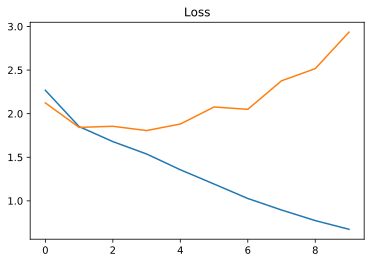

In [0]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.show();

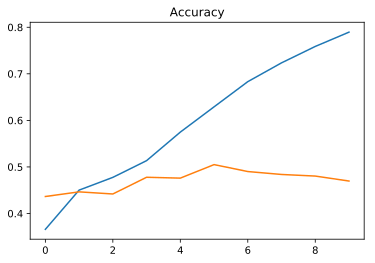

In [0]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.show();

# Submission

In [0]:
test_sequences = tokenize.texts_to_sequences(test_df.text)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=MAX_SEQUENCE_LENGTH)

In [0]:
%%time
predict_proba = model.predict(test_sequences_matrix)

In [0]:
# на соревнованиях всегда сохраняйте predict_proba, чтоб потом можно было построить ансамбль решений
predict_proba = pd.DataFrame(predict_proba, columns=Y.columns)
predict_proba.to_csv('predict_proba.csv', index=False)
predict_proba.head()

In [0]:
predict_genre = Y.columns[np.argmax(predict_proba.values, axis=1)]

In [0]:
submission = pd.DataFrame({'id':range(1, len(predict_genre)+1), 
                           'genre':predict_genre}, 
                          columns=['id', 'genre'])

submission.to_csv('submission.csv', index=False)
submission.head()

Готово!

## Что можно сделать, чтоб улучшить результат:
* Подобрать LR, optimizer, loss
* Поиграться с архитектурой
* Подобрать другие переменные (MAX_WORDS, MAX_SEQUENCE_LENGTH, батч и тп)
* Добавить политику обучения
* Добавить в обучение название фильма (для pro: попробуйте это сделать через concatenate слой)
* Попробовать уже предобученные Векторизаторы (GLOVE, W2V и тд)
* Попробовать уже предобученные модели (BERT, TRANFORMER и тд)
* Построить ансамбль из разных архитектур